In [11]:
import pandas as pd
df = pd.read_csv('Data_Entry_2017.csv')

In [19]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


## VGG16

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import random

# Hyperparameters 
batch_size = 32
image_size = (224, 224)
epochs = 10

# Dataset location 
data_dir = 'E:/archive'
csv_file = os.path.join(data_dir, 'Data_Entry_2017.csv')

# All disease labels
disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 
                'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 
                'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Load & Map Labels from CSV
df = pd.read_csv(csv_file)
image_label_dict = df.set_index('Image Index')['Finding Labels'].to_dict()

# Label preprocessing function
def preprocess_labels(labels_string, disease_list):
    labels = labels_string.split("|")
    one_hot_labels = np.zeros(len(disease_list))  
    for label in labels:
        idx = disease_list.index(label)
        one_hot_labels[idx] = 1
    return one_hot_labels

# Modified Preprocessing and Generator
def custom_generator(data_dir, image_label_dict, image_size, batch_size, image_indices, total_batches_per_epoch):
    images = []  
    labels = [] 
    batches_generated = 0 

    while True:
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):  
                images_subdir = os.path.join(folder_path, 'images')  
                if os.path.isdir(images_subdir):  
                    for image_file in os.listdir(images_subdir):
                        image_path = os.path.join(images_subdir, image_file) 
                        image_index = os.path.basename(image_file) 

                        if image_index in image_indices:  # Check if image is in the intended set
                            label = image_label_dict.get(image_index, 'No Finding')  

                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img, channels=3)  
                            img = tf.image.resize(img, image_size)
                            img = tf.keras.applications.vgg16.preprocess_input(img)  
                            images.append(img)  
                            labels.append(preprocess_labels(label, disease_list))  

                            if len(images) == batch_size:
                                yield tf.stack(images), tf.stack(labels)  
                                images, labels = [], [] 
                                batches_generated += 1

                                if batches_generated == total_batches_per_epoch:
                                    batches_generated = 0 
                                    break  

# Read train_val_list.txt and test_list.txt
with open(os.path.join(data_dir, 'train_val_list.txt')) as f:
    train_val_image_indices = f.read().splitlines()

with open(os.path.join(data_dir, 'test_list.txt')) as f:
    test_image_indices = f.read().splitlines()

# Data Splitting
train_val_indices, test_indices = train_test_split(train_val_image_indices, test_size=0.2, random_state=42)
train_indices, validation_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)

# Calculate batches per epoch
total_training_samples = len(train_indices)
total_validation_samples = len(validation_indices)
total_batches_per_epoch_train = total_training_samples // batch_size
total_batches_per_epoch_val = total_validation_samples // batch_size

# Model (VGG16)
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image_size + (3,))

# Freeze pre-trained layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Head for our classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.05), bias_regularizer='l1')(x)
x = Dropout(0.4)(x)
predictions = Dense(15, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with the custom generator
train_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, train_indices, total_batches_per_epoch_train)
validation_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, validation_indices, total_batches_per_epoch_val)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True 
)

print("Total Training Samples:", total_training_samples)
print("Batch Size:", batch_size)
print("Total Batches per Epoch (Train):", total_batches_per_epoch_train)


# Train the model
model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    steps_per_epoch=total_batches_per_epoch_train,
    validation_steps=total_batches_per_epoch_val,
    callbacks = [early_stopping]
)

# Save the model
model.save(r"C:\Users\jdori\Downloads\chest_xray_model_vgg16.h5")

c:\Users\jdori\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Total Training Samples: 55375
Batch Size: 32
Total Batches per Epoch (Train): 1730
Epoch 1/10
1730/1730 [==============================] - 16527s 10s/step - loss: 0.8562 - accuracy: 0.5807 - val_loss: 0.2135 - val_accuracy: 0.5817
Epoch 2/10
1730/1730 [==============================] - 16591s 10s/step - loss: 0.2092 - accuracy: 0.5853 - val_loss: 0.2149 - val_accuracy: 0.5817
Epoch 3/10
1730/1730 [==============================] - 16529s 10s/step - loss: 0.2124 - accuracy: 0.5843 - val_loss: 0.2152 - val_accuracy: 0.5817
Epoch 4/10
1730/1730 [==============================] - 16574s 10s/step - loss: 0.2058 - accuracy: 0.5854 - val_loss: 0.2128 - val_accuracy: 0.5817
Epoch 5/10
1730/1730 [==============================] - 16471s 10s/step - loss: 0.1984 - accuracy: 0.5854 - val_loss: 0.2094 - val_accuracy: 0.5817
Epoch 6/10
1730/1730 [==============================] - 16335s 9s/step - loss: 0.2037 - accuracy: 0.5848 - val_loss: 0.2114 - val_accuracy: 0.5810
Epoch 7/10
1730/1730 [========

c:\Users\jdori\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## ResNet

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import random

# Hyperparameters 
batch_size = 32
image_size = (224, 224)
epochs = 10

# Dataset location 
data_dir = 'E:/archive'
csv_file = os.path.join(data_dir, 'Data_Entry_2017.csv')

# All disease labels
disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 
                'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 
                'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Load & Map Labels from CSV
df = pd.read_csv(csv_file)
image_label_dict = df.set_index('Image Index')['Finding Labels'].to_dict()

# Label preprocessing function
def preprocess_labels(labels_string, disease_list):
    labels = labels_string.split("|")
    one_hot_labels = np.zeros(len(disease_list))  
    for label in labels:
        idx = disease_list.index(label)
        one_hot_labels[idx] = 1
    return one_hot_labels

# Modified Preprocessing and Generator
def custom_generator(data_dir, image_label_dict, image_size, batch_size, image_indices, total_batches_per_epoch):
    images = []  
    labels = [] 
    batches_generated = 0 

    while True:
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):  
                images_subdir = os.path.join(folder_path, 'images')  
                if os.path.isdir(images_subdir):  
                    for image_file in os.listdir(images_subdir):
                        image_path = os.path.join(images_subdir, image_file) 
                        image_index = os.path.basename(image_file) 

                        if image_index in image_indices:  # Check if image is in the intended set
                            label = image_label_dict.get(image_index, 'No Finding')  

                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img, channels=3)  
                            img = tf.image.resize(img, image_size)
                            img = tf.keras.applications.resnet.preprocess_input(img)  
                            images.append(img)  
                            labels.append(preprocess_labels(label, disease_list))  

                            if len(images) == batch_size:
                                yield tf.stack(images), tf.stack(labels)  
                                images, labels = [], [] 
                                batches_generated += 1

                                if batches_generated == total_batches_per_epoch:
                                    batches_generated = 0 
                                    break  

# Read train_val_list.txt and test_list.txt
with open(os.path.join(data_dir, 'train_val_list.txt')) as f:
    train_val_image_indices = f.read().splitlines()

with open(os.path.join(data_dir, 'test_list.txt')) as f:
    test_image_indices = f.read().splitlines()

# Data Splitting
train_val_indices, test_indices = train_test_split(train_val_image_indices, test_size=0.2, random_state=42)
train_indices, validation_indices = train_test_split(train_val_indices, test_size=0.2, random_state=42)

# Calculate batches per epoch
total_training_samples = len(train_indices)
total_validation_samples = len(validation_indices)
total_batches_per_epoch_train = total_training_samples // batch_size
total_batches_per_epoch_val = total_validation_samples // batch_size

# Model (ResNet50)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=image_size + (3,))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.05), bias_regularizer='l1'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(15, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with the custom generator
train_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, train_indices, total_batches_per_epoch_train)
validation_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, validation_indices, total_batches_per_epoch_val)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True 
)

print("Total Training Samples:", total_training_samples)
print("Batch Size:", batch_size)
print("Total Batches per Epoch (Train):", total_batches_per_epoch_train)

# Train the model
model.fit(
    train_data,
    epochs=epochs,
    validation_data=validation_data,
    steps_per_epoch=total_batches_per_epoch_train,
    validation_steps=total_batches_per_epoch_val,
    callbacks=[early_stopping]
)

# Save the model
model.save(r"C:\Users\jdori\Downloads\chest_xray_model_resnet.h5")

Total Training Samples: 55375
Batch Size: 32
Total Batches per Epoch (Train): 1730
Epoch 1/10
1730/1730 [==============================] - 9355s 5s/step - loss: 3.1904 - accuracy: 0.5401 - val_loss: 3.2126 - val_accuracy: 0.0165
Epoch 2/10
1730/1730 [==============================] - 9245s 5s/step - loss: 2.1368 - accuracy: 0.5700 - val_loss: 2.0693 - val_accuracy: 0.3789
Epoch 3/10
1730/1730 [==============================] - 9893s 6s/step - loss: 1.7498 - accuracy: 0.5749 - val_loss: 1.7741 - val_accuracy: 0.5816
Epoch 4/10
1730/1730 [==============================] - 9995s 6s/step - loss: 1.4703 - accuracy: 0.5772 - val_loss: 1.4317 - val_accuracy: 0.5473
Epoch 5/10
1730/1730 [==============================] - 9561s 6s/step - loss: 1.2345 - accuracy: 0.5796 - val_loss: 1.3912 - val_accuracy: 0.5299
Epoch 6/10
1730/1730 [==============================] - 9572s 6s/step - loss: 1.0813 - accuracy: 0.5804 - val_loss: 1.1867 - val_accuracy: 0.5812
Epoch 7/10
1730/1730 [===================

c:\Users\jdori\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
from flask import Flask, request, jsonify
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

app = Flask(__name__)

# Load your model
model = tf.keras.models.load_model(r'C:\Users\jdori\Downloads\chest_xray_model_vgg16.h5')
image_size = (224, 224)

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
                  'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
                  'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

def preprocess_image(image):
    img = tf.image.resize(image, image_size)
    img = preprocess_input(img)
    return img

def predict_disease(image):
    image = preprocess_image(image)
    prediction = model.predict(tf.expand_dims(image, axis=0))[0]

    results = {
        'predictions': [label for label, prob in zip(disease_labels, prediction) if prob > 0.5],
        'confidence': prediction.tolist()
    }

    return results

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    image = request.files['image'].read()
    image = tf.image.decode_image(image, channels=3)
    
    result = predict_disease(image)
    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True, port=5000)

## ROC Curve - ResNet

1/1 [==============================] - 2s 2s/step


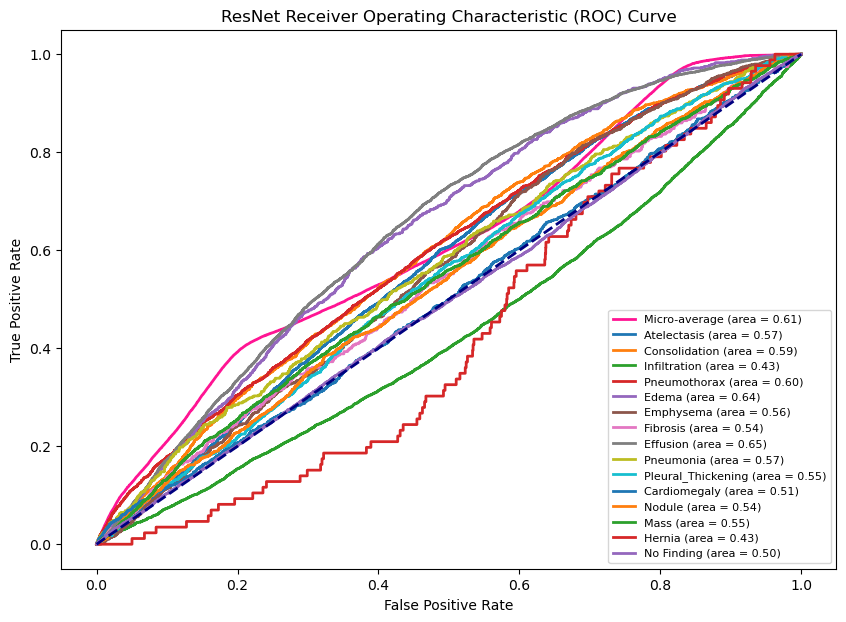

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import os
import pandas as pd
import tensorflow as tf

# Define constants
batch_size = 32
image_size = (224, 224)
data_dir = 'E:/archive'
model_path = r"C:\Users\jdori\Downloads\chest_xray_model_resnet.h5"
csv_file = os.path.join(data_dir, 'Data_Entry_2017.csv')

disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 
                'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 
                'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Load the trained model
model = load_model(model_path)

# Load & Map Labels from CSV
df = pd.read_csv(csv_file)
image_label_dict = df.set_index('Image Index')['Finding Labels'].to_dict()

def preprocess_labels(labels_string, disease_list):
    labels = labels_string.split("|")
    one_hot_labels = np.zeros(len(disease_list))  
    for label in labels:
        idx = disease_list.index(label)
        one_hot_labels[idx] = 1
    return one_hot_labels

def custom_generator(data_dir, image_label_dict, image_size, batch_size, image_indices, total_batches_per_epoch):
    batches_generated = 0

    while True:
        images = []
        labels = []

        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                images_subdir = os.path.join(folder_path, 'images')
                if os.path.isdir(images_subdir):
                    for image_file in os.listdir(images_subdir):
                        image_path = os.path.join(images_subdir, image_file)
                        image_index = os.path.basename(image_file)

                        if image_index in image_indices:
                            label = image_label_dict.get(image_index, 'No Finding')

                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img, channels=3)
                            img = tf.image.resize(img, image_size)
                            img = tf.keras.applications.resnet.preprocess_input(img)
                            images.append(img)
                            labels.append(preprocess_labels(label, disease_list))

                            if len(images) == batch_size:
                                yield np.array(images), np.array(labels)
                                images, labels = [], []
                                batches_generated += 1

                                if batches_generated == total_batches_per_epoch:
                                    batches_generated = 0
                                    break

# Read train_val_list.txt and test_list.txt
with open(os.path.join(data_dir, 'train_val_list.txt')) as f:
    train_val_image_indices = f.read().splitlines()

with open(os.path.join(data_dir, 'test_list.txt')) as f:
    test_image_indices = f.read().splitlines()

# Define the test generator
test_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, test_image_indices, len(test_image_indices) // batch_size)

# Get predictions for the test set
y_true = []
y_score = []

for i in range(len(test_image_indices) // batch_size):
    X_batch, y_batch = next(test_data)
    y_true.extend(y_batch)
    y_score.extend(model.predict(X_batch))

y_true = np.array(y_true)

# Binarize the labels using unique labels in the data
unique_labels = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=np.arange(len(disease_list)))
y_true_bin = np.array(y_true_bin)  # Convert to numpy array

y_score = np.array(y_score)  # Convert to numpy array

# Compute ROC curve and ROC area for each disease
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, disease in enumerate(disease_list):
    fpr[disease], tpr[disease], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[disease] = auc(fpr[disease], tpr[disease])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 7))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, label='Micro-average (area = {:.2f})'.format(roc_auc["micro"]))

# Plot individual class ROC curves
for disease in disease_list:
    plt.plot(fpr[disease], tpr[disease], lw=lw, label='{} (area = {:.2f})'.format(disease, roc_auc[disease]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right", fontsize = 8)
plt.show()

## VGG-16 ROC Curve

1/1 [==============================] - 6s 6s/step


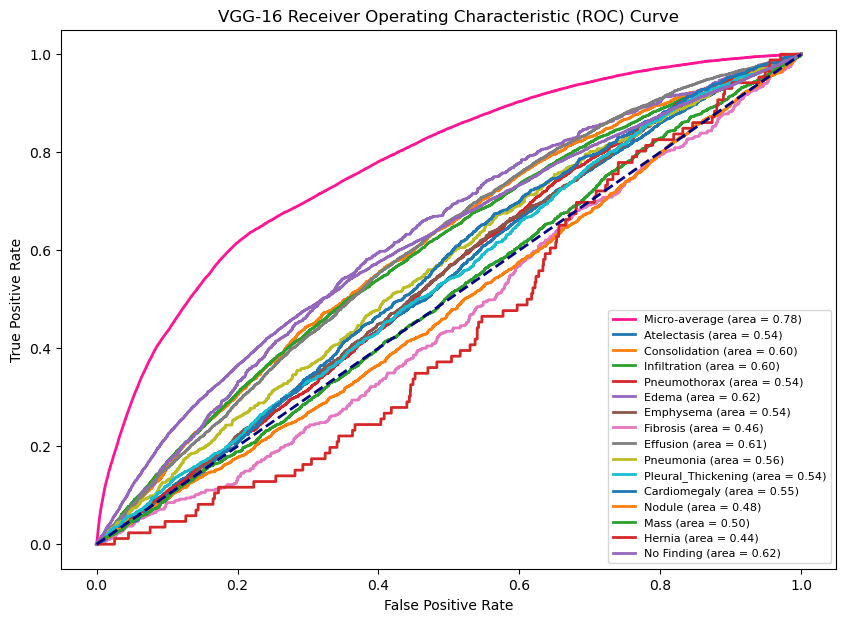

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import os
import pandas as pd
import tensorflow as tf

# Define constants
batch_size = 32
image_size = (224, 224)
data_dir = 'E:/archive'
model_path = r"C:\Users\jdori\Downloads\chest_xray_model_vgg16.h5"
csv_file = os.path.join(data_dir, 'Data_Entry_2017.csv')

disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 
                'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 
                'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

# Load the trained model
model = load_model(model_path)

# Load & Map Labels from CSV
df = pd.read_csv(csv_file)
image_label_dict = df.set_index('Image Index')['Finding Labels'].to_dict()

def preprocess_labels(labels_string, disease_list):
    labels = labels_string.split("|")
    one_hot_labels = np.zeros(len(disease_list))  
    for label in labels:
        idx = disease_list.index(label)
        one_hot_labels[idx] = 1
    return one_hot_labels

def custom_generator(data_dir, image_label_dict, image_size, batch_size, image_indices, total_batches_per_epoch):
    batches_generated = 0

    while True:
        images = []
        labels = []

        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                images_subdir = os.path.join(folder_path, 'images')
                if os.path.isdir(images_subdir):
                    for image_file in os.listdir(images_subdir):
                        image_path = os.path.join(images_subdir, image_file)
                        image_index = os.path.basename(image_file)

                        if image_index in image_indices:
                            label = image_label_dict.get(image_index, 'No Finding')

                            img = tf.io.read_file(image_path)
                            img = tf.image.decode_png(img, channels=3)
                            img = tf.image.resize(img, image_size)
                            img = tf.keras.applications.resnet.preprocess_input(img)
                            images.append(img)
                            labels.append(preprocess_labels(label, disease_list))

                            if len(images) == batch_size:
                                yield np.array(images), np.array(labels)
                                images, labels = [], []
                                batches_generated += 1

                                if batches_generated == total_batches_per_epoch:
                                    batches_generated = 0
                                    break

# Read train_val_list.txt and test_list.txt
with open(os.path.join(data_dir, 'train_val_list.txt')) as f:
    train_val_image_indices = f.read().splitlines()

with open(os.path.join(data_dir, 'test_list.txt')) as f:
    test_image_indices = f.read().splitlines()

# Define the test generator
test_data = custom_generator(data_dir, image_label_dict, image_size, batch_size, test_image_indices, len(test_image_indices) // batch_size)

# Get predictions for the test set
y_true = []
y_score = []

for i in range(len(test_image_indices) // batch_size):
    X_batch, y_batch = next(test_data)
    y_true.extend(y_batch)
    y_score.extend(model.predict(X_batch))

y_true = np.array(y_true)

# Binarize the labels using unique labels in the data
unique_labels = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=np.arange(len(disease_list)))
y_true_bin = np.array(y_true_bin)  # Convert to numpy array

y_score = np.array(y_score)  # Convert to numpy array

# Compute ROC curve and ROC area for each disease
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, disease in enumerate(disease_list):
    fpr[disease], tpr[disease], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[disease] = auc(fpr[disease], tpr[disease])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 7))
lw = 2

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=lw, label='Micro-average (area = {:.2f})'.format(roc_auc["micro"]))

# Plot individual class ROC curves
for disease in disease_list:
    plt.plot(fpr[disease], tpr[disease], lw=lw, label='{} (area = {:.2f})'.format(disease, roc_auc[disease]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG-16 Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right", fontsize = 8)
plt.show()